In [9]:
# Import necessary libraries
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from scipy import fftpack
import pywt

# 
#%matplotlib widget

In [2]:
import os
current_directory = os.getcwd()

relative_path = "kaggle/input/24-exercise1/mhealth24_data_public.npy"
new_path="/Users/anton_heden/Downloads/mhealth24_data_public.npy"

full_path = os.path.join(current_directory, relative_path)

In [3]:
sampling_rate = 128  # Hz
# Load data item containing the PPG, HR, and IMU signals from all phases
data = np.load(new_path,allow_pickle=True).item() # now it is a dict

print('Keys for data:', data.keys())

# Example to extract the data from phase 0
phase0_data =data['phase 0']
phase1_data=data['phase 1']
phase2_data=data['phase 2']
phase3_data=data['phase 3']
phase4_data=data['phase 4']
phase5_data=data['phase 5']

# Get the individual signals from phase 0
ppg_phase0 = phase0_data['PPG wrist']
ppg_phase2= phase2_data['PPG head']
ppg_phase4= phase4_data['PPG head']

# Concatenate the data from ppg_phase0, ppg_phase2, and ppg_phase4
ppg_all_traning_data = np.concatenate((ppg_phase0, ppg_phase2, ppg_phase4))

#HR
ref_hr_phase0 = phase0_data['ground truth HR']  # only available for phase 0, 2, and 4 (training data)
ref_hr_phase2 = phase2_data['ground truth HR']
ref_hr_phase4 = phase4_data['ground truth HR']
ref_hr_phase_all = np.concatenate((ref_hr_phase0, ref_hr_phase2, ref_hr_phase4))

# X 
IMU_X_phase0 = phase0_data['IMU X wrist']
IMU_X_phase2 = phase2_data['IMU X head']
IMU_X_phase4 = phase4_data['IMU X head']
IMU_X_all = np.concatenate((IMU_X_phase0, IMU_X_phase2, IMU_X_phase4))

# Y
IMU_Y_phase0 = phase0_data['IMU Y wrist']
IMU_Y_phase2 = phase2_data['IMU Y head']
IMU_Y_phase4 = phase4_data['IMU Y head']
IMU_Y_all = np.concatenate((IMU_Y_phase0, IMU_Y_phase2, IMU_Y_phase4))

# Z
IMU_Z_phase0 = phase0_data['IMU Z wrist']
IMU_Z_phase2 = phase2_data['IMU Z head']
IMU_Z_phase4 = phase4_data['IMU Z head']
IMU_Z_all = np.concatenate((IMU_Z_phase0, IMU_Z_phase2, IMU_Z_phase4))


#All IMU 
IMU_all=np.array([IMU_X_all,IMU_Y_all,IMU_Z_all]).T

Keys for data: dict_keys(['phase 0', 'phase 1', 'phase 2', 'phase 3', 'phase 4', 'phase 5'])


Functions

In [4]:
import numpy as np
import numpy as np
# Function to plot any signal with time on the x-axis

def plot_signal(signal1, title='Signal', ylabel='time', sampling_rate=128):
    x = np.linspace(0, np.shape(signal1)[0] / sampling_rate, len(signal1))
    t = pd.to_datetime(x, unit='s')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 6))
    if len(np.shape(signal1))>1:
        for i in range(np.shape(signal1)[1]):
            ax1.plot(x/(30), signal1[:,i])
        ax1.legend(['0', '1', '2'])       
    else: 
        peak_postions=get_peaks(signal1)
        ax1.plot(t, signal1)
        ax1.plot(t[peak_postions], signal1[peak_postions], 'ro')  
        ax1.set_xlabel('Time [min:sec]')
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
  
    ax1.set_title(title)
    ax1.set_ylabel(ylabel)

    xf,yf=frequency_spectrum(signal1,sampling_rate)
    ax2.plot(xf, yf)
    ax2.set_title('Frequency spectrum')
    ax2.set_xlabel('Frequency [Hz]')

    
    plt.show()

#sktime
# filter out the problem areas with accelermometer 
    # plot a slider in the final graph for the diffrent thresholds to be able to easy manipulate them   pr make palne with the diffrent parameters and the erro as function value and minimizet that  
def filter_signal(sig, lowHR, highHR, sampling_rate):
    low=lowHR/60
    high=highHR/60
    sos = signal.butter(3, [low,high], 'bandpass', fs=sampling_rate, output='sos')
    if len(np.shape(sig))>1:
        filtered_signal=np.zeros(np.shape(sig))
        for i in range(np.shape(sig)[1]):
            filtered_signal[:,i] = signal.sosfilt(sos, sig[:,i])
    else:       
        filtered_signal = signal.sosfilt(sos, sig)
    return filtered_signal


def frequency_spectrum(sig, sampling_rate):
    fft = fftpack.fft(sig)
    frequencies = np.fft.fftfreq(len(sig), 1/sampling_rate)
    return frequencies[:len(fft)//2], np.abs(fft[:len(fft)//2])



def get_bpm_with_highest_amplitude(signal, sampling_rate):
    # Compute the Fast Fourier Transform (FFT) of the signal
    fft = np.fft.fft(signal)
    # Compute the frequencies corresponding to the FFT
    frequencies = np.fft.fftfreq(len(signal), 1/sampling_rate)
    # Find the index of the maximum amplitude in the FFT result
    max_amplitude_index = np.argmax(np.abs(fft))
    # Get the frequency with the highest amplitude
    frequency_with_highest_amplitude = frequencies[max_amplitude_index]
    return frequency_with_highest_amplitude*60

def get_bpm_with_count_peaks(signal_1d,duration=30):
    peakpostions=get_peaks(signal_1d)#,height=heigth_of_peak,distance=(lowHR/60)*sampling_rate)) #(highHR/60)*sampling_rate]))
    return  len(peakpostions)*(60/duration)

def get_bpm_with_measure_distance_beetweens_peaks(signal_1d,sampling_rate=128):
    peak_postions=get_peaks(signal_1d)
    print(peak_postions)
    distance_beetween_peaks=peak_postions[1:]-peak_postions[:-1]
    return 60/(np.mean(distance_beetween_peaks)/sampling_rate)

def get_peaks(sig,distance=(60/180),sampling_rate=128,height=None,threshold=None):# height=[1000,10**5]
    distance_samples=distance*sampling_rate
    peaks_positions,empty=(signal.find_peaks(sig,distance=distance_samples,threshold=threshold,height=height))
    return peaks_positions

def print_score(pred_hr, ref_hr):
    err = np.abs(np.asarray(pred_hr) - np.asarray(ref_hr))
    print("Mean error: {:4.3f}, Median error {:4.3f}".format(np.mean(err), np.median(err)))
    print("Resulting score {:4.3f}".format(0.5 * np.mean(err) + 0.5 * np.median(err)))
    
def get_intervall(sig,intervall,window_size_sec=30,sampling_rate=128):
    if len(np.shape(sig))>1:
        return sig[intervall[0]*window_size_sec*sampling_rate:intervall[1]*window_size_sec*sampling_rate,:]
    return sig[intervall[0]*window_size_sec*sampling_rate:intervall[1]*window_size_sec*sampling_rate]

def get_peaks2(sig, distance=(60/180), sampling_rate=128, height=None, threshold=None):
    distance_samples = distance * sampling_rate
    peaks_positions, empty = (signal.find_peaks(sig, distance=None, threshold=threshold, height=height))
    
    # Calculate the previous distance between peaks
    prev_distance = np.diff(peaks_positions)
    average_prev_distance = np.mean(prev_distance[:5])
    
    # Calculate the window size based on the previous peak and distance
    def calculate_window_size(average_prev_distance):
        window_size = [average_prev_distance - (average_prev_distance * 0.1), average_prev_distance + (average_prev_distance * 0.1)]
        return window_size
    window_size=[40/60,180/60]
    #window_size = [average_prev_distance - (average_prev_distance * 0.1),average_prev_distance+ (average_prev_distance * 0.1)]
    #print(len(window_size))
    print(average_prev_distance)
    
    # Filter peaks within the window size
    filtered_peaks = []
    for i in range(len(peaks_positions) - 1):
        print(prev_distance[i],window_size[i])
        if window_size[0]<= prev_distance[i] <= window_size[1]:
            filtered_peaks.append(peaks_positions[i])
            window_size=calculate_window_size(prev_distance[i])
            print(prev_distance[i])
            print(i)
        print("Done loop filtering peaks!")
    return filtered_peaks

def my_get_peaks(sig):
    second_derivative = np.gradient(np.gradient(sig))
    derivative = np.gradient(signal)




Filter the signal

Create Test signal

(3260160, 3)


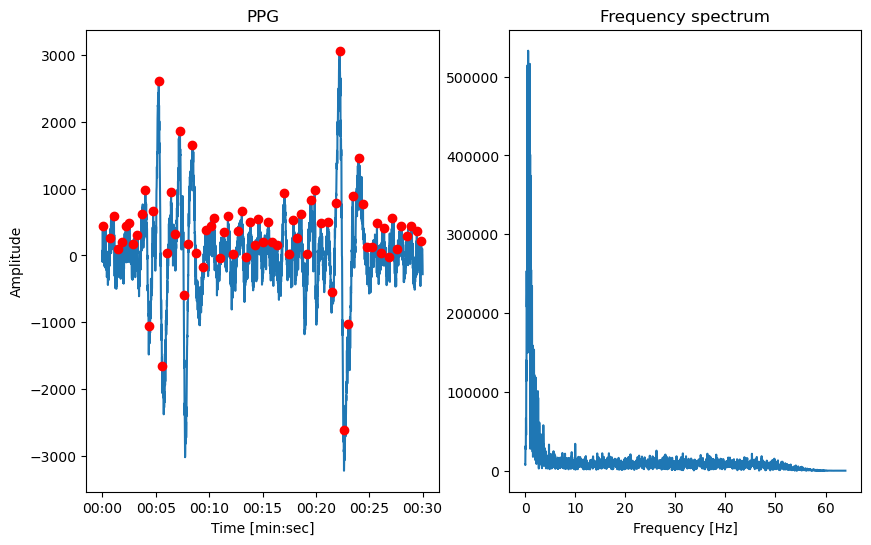

144.0
[   4   85  134  184  230  279  324  371  417  469  515  564  608  675
  718  780  823  867  929  975 1031 1077 1121 1200 1246 1296 1340 1411
 1454 1504 1570 1626 1671 1722 1775 1824 1870 1929 1985 2030 2096 2180
 2233 2288 2337 2385 2454 2499 2544 2617 2703 2750 2797 2843 2892 2945
 3001 3074 3118 3170 3236 3291 3334 3377 3430 3476 3531 3580 3653 3702
 3769 3814]
143.11811023622047
[73.10417768]


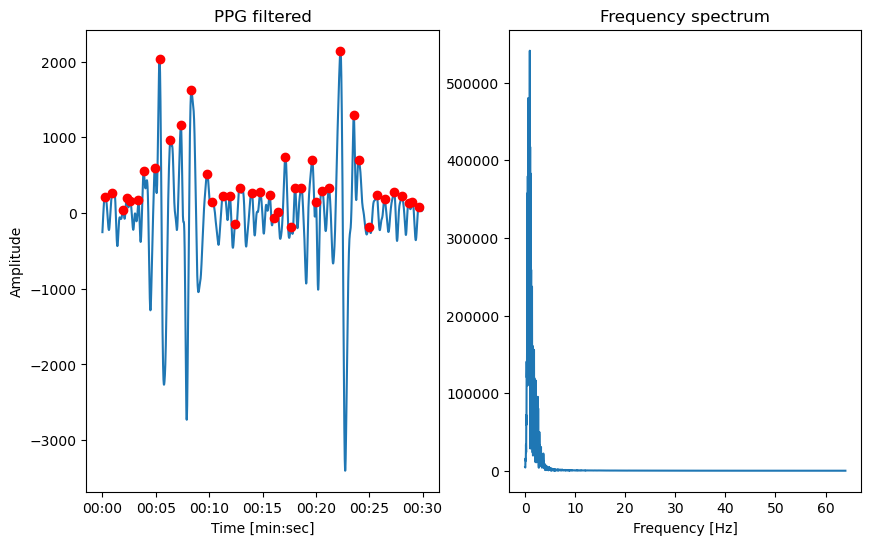

84.0
[  29  120  247  291  335  432  494  628  685  815  940 1067 1256 1317
 1443 1526 1592 1646 1789 1893 2005 2052 2101 2194 2262 2310 2386 2515
 2559 2628 2715 2854 3013 3071 3196 3286 3382 3497 3592 3670 3717 3793]
83.65568544102018
[73.10417768]


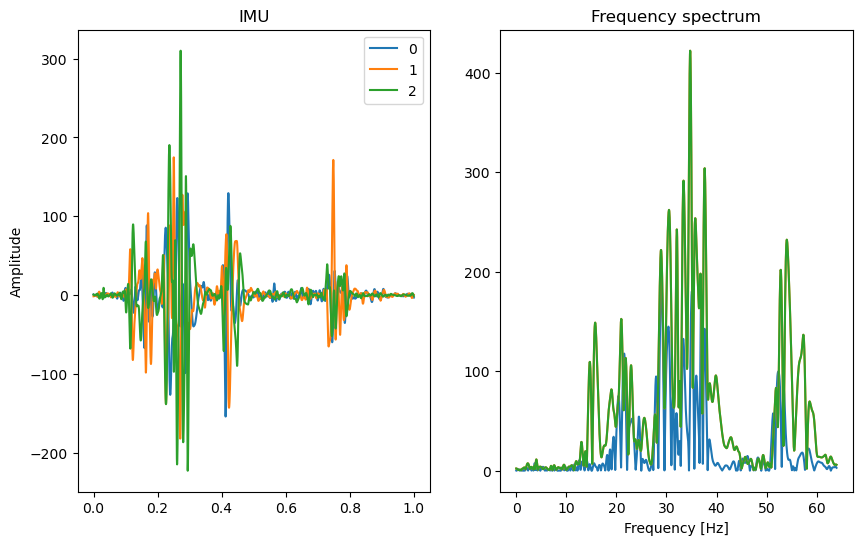

In [5]:
intervall=[152,153]

#PROBLEM Area [150,400]

signal_filtered=filter_signal(ppg_all_traning_data,40,180,128)
signal_HP_filtered=filter_signal(ppg_all_traning_data,40,3000,128)
shown_signal=get_intervall(signal_HP_filtered,intervall)
shown_signal_filtered=get_intervall(signal_filtered,intervall)

IMU_all_filtered=filter_signal(IMU_all,40,180,128)
print(IMU_all_filtered.shape)
shown_IMU=get_intervall(IMU_all_filtered,intervall)


#subplot_signal(test_signal,test_signal_filtred, 'PPG wrist', 'Amplitude', 128)
plot_signal(shown_signal, 'PPG', 'Amplitude', 128)
print(get_bpm_with_count_peaks(shown_signal,duration=30*(intervall[1]-intervall[0])))
print(get_bpm_with_measure_distance_beetweens_peaks(shown_signal))
print(ref_hr_phase_all[intervall[0]:intervall[1]])

plot_signal(shown_signal_filtered, 'PPG filtered', 'Amplitude', 128)
print(get_bpm_with_count_peaks(shown_signal_filtered,duration=30*(intervall[1]-intervall[0])))
print(get_bpm_with_measure_distance_beetweens_peaks(shown_signal_filtered))
print(ref_hr_phase_all[intervall[0]:intervall[1]])



plot_signal(shown_IMU, 'IMU', 'Amplitude', 128)



#%matplotlib widget


#plot_frequency_spectrum(filtered_signal_but, 128)
#print(get_bpm_with_highest_amplitude(filtered_signal_but, 128))

#plot_frequency_spectrum(test_signal_filtred, 128)
#print(get_bpm_with_highest_amplitude(test_signal_filtred, 128))




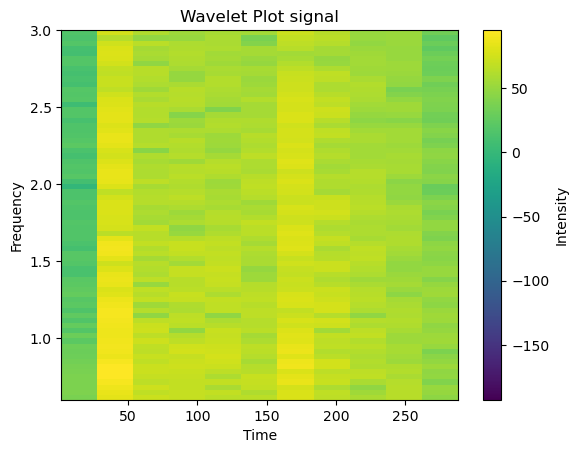

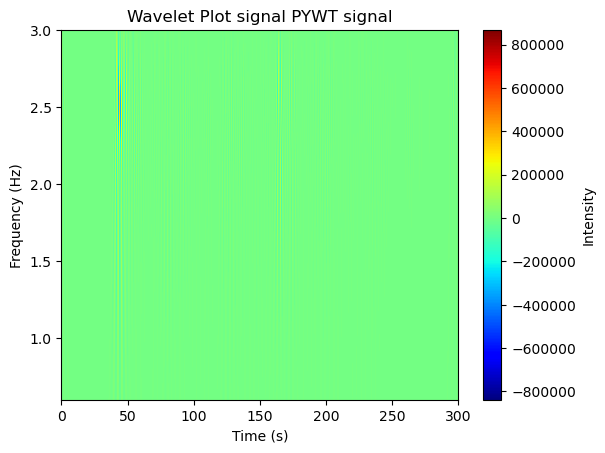

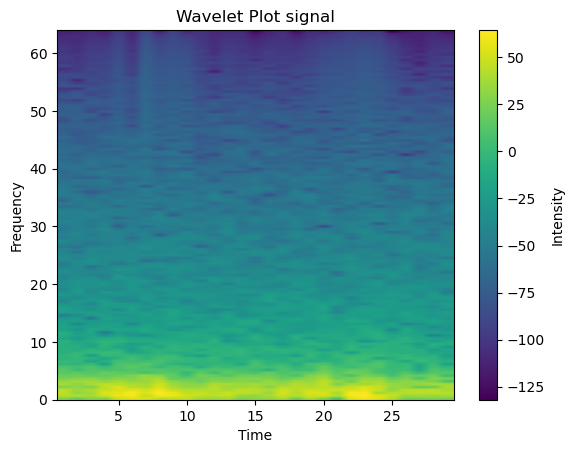

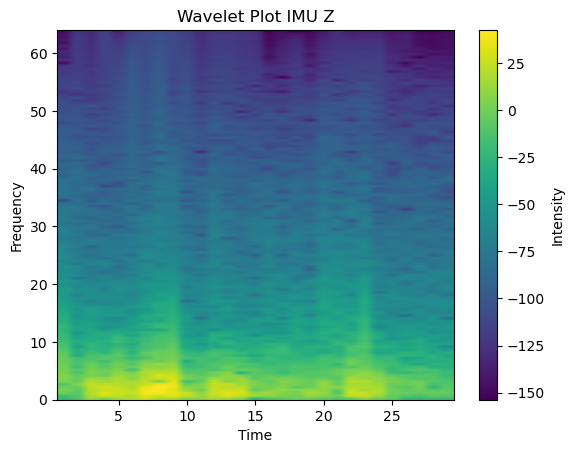

In [6]:
import pywt

plt.figure()
plt.specgram(signal_filtered[:128*30*10], Fs=sampling_rate, NFFT=int(30 * sampling_rate), noverlap=int(4 * sampling_rate))
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Wavelet Plot signal')
plt.colorbar(label='Intensity')
plt.ylim(0.6, 3)
# Define the signal and its parameters
signal = signal_filtered[:128*30*10]
sampling_rate = 128
frequency_range = (0.6, 3)

# Perform continuous wavelet transform
coefficients, frequencies = pywt.cwt(signal, range(int(frequency_range[0]*sampling_rate), int(frequency_range[1]*sampling_rate)), 'morl')

# Plot the wavelet coefficients
plt.figure()
plt.imshow(coefficients, aspect='auto', cmap='jet', extent=[0, len(signal)/sampling_rate, frequency_range[0], frequency_range[1]])
plt.colorbar(label='Intensity')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Wavelet Plot signal PYWT signal')
plt.show()


plt.figure()
plt.specgram(shown_signal_filtered, Fs=sampling_rate, NFFT=256, noverlap=128)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Wavelet Plot signal')
plt.colorbar(label='Intensity')
plt.show()

plt.figure()
plt.specgram(shown_IMU[:,2], Fs=sampling_rate, NFFT=256, noverlap=128)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Wavelet Plot IMU Z')
plt.colorbar(label='Intensity')
plt.show()







In [10]:
# perform CWT



import pywt
import matplotlib.pyplot as plt
import numpy as np

import pywt


def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)


def make_shown_signal_filtered(t, t0, a):
    frequency = (a * (t + t0)) ** 2
    shown_signal_filtered = np.sin(2 * np.pi * frequency * t)
    return shown_signal_filtered, frequency


# generate signal
time = np.linspace(0, 1, 2000)
shown_signal_filtered1, frequency1 = make_shown_signal_filtered(time, 0.2, 9)
chirp2, frequency2 = make_chirp(time, 0.1, 5)
chirp = chirp1 + 0.6 * chirp2
chirp *= gaussian(time, 0.5, 0.2)


# plot signal
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(time, chirp)
axs[1].plot(time, frequency1)
axs[1].plot(time, frequency2)
axs[1].set_yscale("log")
axs[1].set_xlabel("Time (s)")
axs[0].set_ylabel("Signal")
axs[1].set_ylabel("True frequency (Hz)")
plt.suptitle("Input signal")
plt.show()
wavelet = "cmor1.5-1.0"
# logarithmic scale for scales, as suggested by Torrence & Compo:
widths = np.geomspace(1, 1024, num=100)
sampling_period = np.diff(time).mean()
cwtmatr, freqs = pywt.cwt(chirp, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(chirp)
xf = rfftfreq(len(chirp), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()



NameError: name 'make_chirp' is not defined

In [ ]:
# plot signal

# generate signal
shown_signal_filtered
def get_freq_over_time(sig,sampling_rate):
    time = np.linspace(0, 30, 30*sampling_rate)

    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].plot(time,sig )
    #axs[1].plot(time, frequency1)
    #axs[1].plot(time, frequency2)
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Time (s)")
    axs[0].set_ylabel("Signal")
    axs[1].set_ylabel("True frequency (Hz)")
    plt.suptitle("Input signal")
    plt.show()
    wavelet = "cmor1.5-1.0"
    # logarithmic scale for scales, as suggested by Torrence & Compo:
    widths = np.geomspace(1, 1024, num=100)
    sampling_period = np.diff(time).mean()
    cwtmatr, freqs = pywt.cwt(shown_signal_filtered, widths, wavelet, sampling_period=sampling_period)
    # absolute take absolute value of complex result
    cwtmatr = np.abs(cwtmatr[:-1, :-1])

    # plot result using matplotlib's pcolormesh (image with annoted axes)
    fig, axs = plt.subplots(2, 1)
    pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
    axs[0].set_yscale("log")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Frequency (Hz)")
    axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
    fig.colorbar(pcm, ax=axs[0])

    # plot fourier transform for comparison
    from numpy.fft import rfft, rfftfreq
    import numpy as np

    yf = rfft(shown_signal_filtered)
    xf = rfftfreq(len(shown_signal_filtered), sampling_period)
    plt.semilogx(xf, np.abs(yf))
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_title("Fourier Transform")
    plt.tight_layout()
    # Get the frequency with the highest amplitude in every time window and do the sam for shown_IMU[:,2]
    cwtmatr, freqs = pywt.cwt(shown_signal_filtered, widths, wavelet, sampling_period=sampling_period)
    cwtmatr = np.abs(cwtmatr)

    max_freqs = freqs[np.argmax(cwtmatr, axis=0)]

    window_size = 128 * 3
    medians = []
    for i in range(0, len(max_freqs), window_size):
        window = max_freqs[i:i+window_size]
        median = np.median(window)
        medians.append(median)


    print(medians)

    import matplotlib.pyplot as plt

    time_window = range(len(medians))
    medians_minutes = [median * 60 for median in medians]

    plt.figure()
    plt.plot(time_window, medians_minutes)
    plt.xlabel("Time Window")
    plt.ylabel("Medians * 60")
    plt.title("Medians multiplied by 60 over Time")
    plt.show()




# Print the frequency with the highest amplitude in each time window
for i, freq in enumerate(max_freqs):
    print(f"Time window {i+1}: Frequency with highest amplitude = {freq} Hz")


Calculate the avarage bpm value

Create test signal 

In [ ]:
# Define the parameters
duration = 8*60  # seconds
sampling_rate = 128  # Hz
heart_rates=[0,180,2000]
frequencies = [rate/60 for rate in heart_rates]
print(frequencies)

#frequencies = heart_rates//60 # Hz
amplitudes = [2, 1, 0.9]  # a.u.

# Calculate the number of samples
num_samples = int(duration * sampling_rate)

# Generate the time axis
time = np.arange(num_samples) / sampling_rate

# Generate the signal
test_signal = amplitudes[0]*np.sin(2 * np.pi * frequencies[0] * time) + amplitudes[1]*np.sin(2 * np.pi * frequencies[1] * time) + amplitudes[0]*np.sin(2 * np.pi * frequencies[2] * time)
test_signal_filtred=filter_signal(test_signal,40,180,128)


heart rate ploted over a day

In [13]:
import numpy as np

def get_bpm_over_time(sig,sampling_rate=128,sampling_time_signal=30,lowHR=40,highHR=180):
    bpms=np.zeros(int(np.floor(len(sig)/(sampling_time_signal*sampling_rate))))
    j=0
    sig_filt=filter_signal(sig,lowHR,highHR,sampling_rate)

    for i in range(0, len(sig_filt)-sampling_time_signal*sampling_rate, sampling_time_signal*sampling_rate):
        this_signal = sig_filt[i:i+sampling_time_signal*sampling_rate]
        bpms[j] = get_bpm_with_measure_distance_beetweens_peaks(this_signal,sampling_rate)
        j+=1
    return bpms

%matplotlib qt


#filtred_signal_but_full= butterworth_filter_signal(ppg_phase0,40,180,128)

pred_hr=get_bpm_over_time(ppg_all_traning_data)

pred_hr[-1]=pred_hr[-2]

xTimes = np.arange(0, len(pred_hr))
plt.figure(figsize=(30,6))
import matplotlib.pyplot as plt

IMU_all_filtered=filter_signal(IMU_all,40,180,128)
IMU_X_filtred=IMU_all_filtered[:,0]
IMU_Y_filtred=IMU_all_filtered[:,1]
IMU_Z_filtred=IMU_all_filtered[:,2]
# Calculate the absolute average over every 30*128 samples
abs_avg_x = np.mean(np.abs(IMU_X_filtred.reshape(-1, 30*128)), axis=1)
abs_avg_y = np.mean(np.abs(IMU_Y_filtred.reshape(-1, 30*128)), axis=1)
abs_avg_z = np.mean(np.abs(IMU_Z_filtred.reshape(-1, 30*128)), axis=1)

# Normalize the values from 40 to 180 
from_min=80
to_max= 160-from_min
normalized_vals_x = (abs_avg_x - np.min(abs_avg_x)) * (to_max / (np.max(abs_avg_x) - np.min(abs_avg_x)))+from_min
normalized_vals_y = (abs_avg_y - np.min(abs_avg_y)) * (to_max / (np.max(abs_avg_y) - np.min(abs_avg_y)))+from_min
normalized_vals_z = (abs_avg_z - np.min(abs_avg_z)) * (to_max/ (np.max(abs_avg_z) - np.min(abs_avg_z)))+from_min

# Plot the data
plt.plot(normalized_vals_x,'--', label='X',alpha=0.3)
plt.plot(normalized_vals_y,'--', label='Y',alpha=0.3)
plt.plot(normalized_vals_z, '--',label='Z',alpha=0.3)
plt.xlabel('Sample Index')
plt.ylabel('Normalized Value')
plt.title('Absolute Average over every 30*128 samples of IMU_all_filtered')


plt.plot(xTimes, ref_hr_phase_all, label='Reference HR')
plt.plot(xTimes, pred_hr, label='Predicted HR')
plt.title('Reference vs Predicted HR')

plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

# Function to print the mean and median absolute error between your predicted HR and the reference HR
# With this function, you can evaluate the resulting score that you would obtain on the public dataset
# with your predicted HR values on Kaggle


# Example on how to use the print_score function with randomly generated HR values as the predictions
 #list(np.random.randint(40, 180, len(ref_hr_phase0)))
print(np.max(np.diff(ref_hr_phase_all)))
print_score(pred_hr, ref_hr_phase_all)


#xTimes=np.arange(0, len(predicted_bpms))
#plt.plot(xTimes,predicted_bpms)
#plt.show()

[  23  143  336  530  620  664  724  767  814  867  911  977 1037 1083
 1185 1228 1277 1339 1400 1450 1495 1575 1645 1708 1758 1801 1879 1968
 2100 2193 2277 2324 2385 2439 2484 2561 2648 2779 2860 2907 2987 3059
 3114 3166 3239 3296 3351 3395 3476 3520 3579 3631 3737 3780]
[   5   89  138  182  237  294  352  438  500  578  661  778  822  911
 1010 1097 1142 1228 1353 1442 1523 1621 1786 1834 1943 1988 2109 2179
 2246 2290 2354 2424 2474 2580 2628 2680 2742 2869 2926 3038 3123 3217
 3338 3440 3492 3538 3666 3742 3793]
[   2  190  278  361  409  518  587  660  707  810  873  948 1023 1106
 1180 1227 1340 1496 1561 1727 1839 1977 2069 2171 2297 2452 2546 2634
 2794 2860 2916 2976 3088 3179 3382 3553 3683 3792]
[  38  222  284  368  494  673  779  865  953 1057 1255 1323 1399 1475
 1577 1656 1793 1842 1967 2062 2138 2187 2256 2335 2432 2511 2580 2624
 2717 2906 3100 3223 3311 3370 3468 3571 3634 3747 3827]
[  21  125  215  292  384  514  652  767  851  935  978 1052 1119 1261
 1373 1487 

In [ ]:
#plot the IMU data

plot_signal(IMU_all_filtered, 'IMU', 'Amplitude', 128)

In [ ]:
# Function to print the mean and median absolute error between your predicted HR and the reference HR
# With this function, you can evaluate the resulting score that you would obtain on the public dataset
# with your predicted HR values on Kaggle
def print_score(pred_hr, ref_hr):
    err = np.abs(np.asarray(pred_hr) - np.asarray(ref_hr))
    print("Mean error: {:4.3f}, Median error {:4.3f}".format(np.mean(err), np.median(err)))
    print("Resulting score {:4.3f}".format(0.5 * np.mean(err) + 0.5 * np.median(err)))

# Example on how to use the print_score function with randomly generated HR values as the predictions
pred_hr_phase0 = list(np.random.randint(40, 180, len(ref_hr_phase0)))
print_score(pred_hr_phase0, ref_hr_phase0)

In [ ]:
# For each phase, you should now have obtained a list of predicted HR values
# Below, we give an example of how you can produce the submission.csv file from your predicted HR values
# To demonstrate the format of the submission.csv file, we provide an example with randomly generated HR values
# For phase 0, 1, 2, and 3 you should each obtain 396 HR values
# For phase 4 and 5 you should each obtain 57 HR values
# IMPORTANT: You have to replace the following predicted HR values with your predicted HR values!
pred_hr_phase0 = list(np.random.randint(40, 180, 396))
pred_hr_phase1 = list(np.random.randint(40, 180, 396))
pred_hr_phase2 = list(np.random.randint(40, 180, 396))
pred_hr_phase3 = list(np.random.randint(40, 180, 396))
pred_hr_phase4 = list(np.random.randint(40, 180, 57))
pred_hr_phase5 = list(np.random.randint(40, 180, 57))

# You can keep the below code unchanged to produce the submission.csv file
pred_hr_phases = [pred_hr_phase0, pred_hr_phase1, pred_hr_phase2,
                  pred_hr_phase3, pred_hr_phase4, pred_hr_phase5]
ids = []
pred_hr_flattened = []

for phase_counter in range(len(pred_hr_phases)):
    for hr_counter in range(len(pred_hr_phases[phase_counter])):
        pred_hr_flattened.append(pred_hr_phases[phase_counter][hr_counter])
        ids.append(f'phase{phase_counter}_{hr_counter}')


relative_path_result = "/kaggle/working/submission.csv"
full_path_result = os.path.join(current_directory, relative_path)
# If you use Kaggle, on the right side in tab "Output", you should now see a file called "submission.csv" after pressing "refresh"
# Download the file and submit it to the competition on Kaggle to obtain a score on the leaderboard for your team
df = pd.DataFrame({'Id': ids, 'Predicted': pred_hr_flattened})
df.to_csv(full_path_result, index=False)

TEST not related to the result 

Create test signal 

In [ ]:
# Define the parameters
duration = 30  # seconds
sampling_rate = 128  # Hz
frequencies = [2, 0.4, 3.5]  # Hz
amplitudes = [0.3, 0.4, 0.7]  # a.u.

# Calculate the number of samples
num_samples = int(duration * sampling_rate)

# Generate the time axis
time = np.arange(num_samples) / sampling_rate

# Generate the signal
test_signal = amplitudes[0]*np.sin(2 * np.pi * frequencies[0] * time) + amplitudes[1]*np.sin(2 * np.pi * frequencies[1] * time) + amplitudes[0]*np.sin(2 * np.pi * frequencies[2] * time)
test_signal_filtred=filter_signal(test_signal,40,180,128)

plt.figure()
x,y=frequency_spectrum(test_signal_filtred, 128)
# Plot the frequencies and the absolute values of the FFT
plt.plot(x,y)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('FFT of Signal')
plt.show()
